#Clustering on Vehicle dataset
Suppose that an automobile manufacturer has developed prototypes for a new vehicle. Before introducing the new model into its range, the manufacturer wants to determine which existing vehicles on the market are most like the prototypes, which group is the most similar with the model, and therefore which models they will be competing against.

Our objective here, is to use clustering methods, to find the most distinctive clusters of vehicles. It will summarize the existing vehicles and help manufacturers to make decision about the supply of new models.

First of all, we are going to import libraries,and download and read the data:

In [ ]:
!pip install sklearn
import numpy as np
import pandas as pd
import sklearn
from scipy import ndimage
from scipy.cluster import hierarchy
from scipy.spatial import distance_matrix
from matplotlib import pyplot as plt
from sklearn import manifold, datasets
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_blobs
%matplotlib inline

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
!wget -O cars_clus.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%204/data/cars_clus.csv

filename ='cars_clus.csv'
pdf =pd.read_csv(filename)
print("Shape of dataset: ", pdf.shape)

pdf.head(5)

--2024-01-11 13:00:03--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%204/data/cars_clus.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.45.118.108
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.45.118.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17774 (17K) [text/csv]
Saving to: ‘cars_clus.csv’

cars_clus.csv       100%[===================>]  17.36K  --.-KB/s    in 0.02s   

2024-01-11 13:00:04 (939 KB/s) - ‘cars_clus.csv’ saved [17774/17774]

Shape of dataset:  (159, 16)


,manufact,model,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,partition
0,Acura,Integra,16.919,16.360,0.000,21.500,1.800,140.000,101.200,67.300,172.400,2.639,13.200,28.000,2.828,0.0
1,Acura,TL,39.384,19.875,0.000,28.400,3.200,225.000,108.100,70.300,192.900,3.517,17.200,25.000,3.673,0.0
2,Acura,CL,14.114,18.225,0.000,$null$,3.200,225.000,106.900,70.600,192.000,3.470,17.200,26.000,2.647,0.0
3,Acura,RL,8.588,29.725,0.000,42.000,3.500,210.000,114.600,71.400,196.600,3.850,18.000,22.000,2.150,0.0
4,Audi,A4,20.397,22.255,0.000,23.990,1.800,150.000,102.600,68.200,178.000,2.998,16.400,27.000,3.015,0.0


The feature sets include price in thousands (price), engine size (engine_s), horsepower (horsepow), wheelbase (wheelbas), width (width), length (length), curb weight (curb_wgt), fuel capacity (fuel_cap) and fuel efficiency (mpg).

##Data Cleaning

We are going to clean the dataset by dropping the rows that have null value:

In [ ]:
print("Shape of dataset before cleaning: ", pdf.size)
pdf[[ 'sales', 'resale','type', 'price','engine_s','horsepow', 'wheelbas', 'widht', 'curb_wgt', 'fuel_cap','mpg', 'lnsales']] = pdf[['sales','resale', 'type','price','engine_s','horsepow','wheelbas', 'width', 'curb_wgt', 'fuel_cap','mpg', 'lnsales']].apply(pd.to_numeric, errors='coerce')
pdf = pdf.dropna()
pdf = pdf.reset_index(drop=True)
print("Shape of datset after cleaning: ", pdf.size)
pdf.head(5)


NameError: name 'pdf' is not defined

Now select our feature set:

In [ ]:
featureset = pdf [['engine_s',  'horsepow', 'wheelbas', 'width', 'curb_wgt', 'fuel_cap', 'mpg']]

Thereupon we can normalize the feature set. **MinMaxScaler** transform features by scaling each feature to a given range, which is (0.1) by default.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
x = featureset.values
min_max_scaler = MinMaxScaler()
feature_mtx = min_max_scaler.fit_transform(x)
feature_mtx[0:5]

array([[0.11428571, 0.21518987, 0.18655098, 0.28143713, 0.2310559 ,
        0.13364055, 0.43333333],
       [0.31428571, 0.43037975, 0.3362256 , 0.46107784, 0.50372671,
        0.31797235, 0.33333333],
       [0.35714286, 0.39240506, 0.47722343, 0.52694611, 0.60714286,
        0.35483871, 0.23333333],
       [0.11428571, 0.24050633, 0.21691974, 0.33532934, 0.34254658,
        0.28110599, 0.4       ],
       [0.25714286, 0.36708861, 0.34924078, 0.80838323, 0.5173913 ,
        0.37788018, 0.23333333]])

##Clustering using scikit-learn
In this section we use scikit-learn package to cluster the dataset. First, we calculate the distance matrix.




In [ ]:
dist_matrix = sklearn.metrics.pairwise.euclidean_distances(feature_mtx, feature_mtx)



In agglomerative clustering,at ech iteration, the algotrithm must update the distance matrix to reflect the distance of the newly formed cluster witg the remaining clusters in the forest. The following methods are supported in Sklearn for calculating the distance between the newly formed cluster and each: single- complete - average- weighted - centroid.

We are going to use **complete** in here.

In [ ]:
Z_using_dist_matrix = hierarchy.linkage(dist_matrix, 'complete')

<ipython-input-18-bf9ca02f569b>:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_using_dist_matrix = hierarchy.linkage(dist_matrix, 'complete')


Let's plot the dendogram:

In [ ]:
fig = plt.figure(figsize=(18,50))
def llf(id):
  return '[%s %s %s]' % (pdf['manufact'][id], pdf['model'][id], int(float(pdf['type'][id])))

dendro = hierarchy.dendrogram(Z_using_dist_matrix, leaf_label_func = llf, leaf_rotation=0, leaf_font_size=12, orientation ='right')


NameError: name 'Z_using_dist_matrix' is not defined

<Figure size 1800x5000 with 0 Axes>

Now we can use the AgglomerativeClustering function from scikit-learn library to cluster the dataset. The AgglomerativeClustering performs a hierarchical clustering using borrom uop approach. The linkage criteria determines the metric used for the merge strategy.

In [ ]:
agglom = AgglomerativeClustering(n_clusters = 6, linkage = 'complete')
agglom.fit(dist_matrix)

agglom.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:544: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


array([1, 2, 3, 1, 3, 3, 1, 2, 2, 2, 3, 2, 3, 3, 2, 1, 1, 2, 2, 2, 3, 4,
       5, 1, 1, 2, 1, 3, 1, 1, 1, 0, 0, 0, 0, 3, 3, 4, 2, 1, 2, 3, 3, 3,
       0, 1, 0, 4, 1, 1, 3, 3, 4, 1, 1, 2, 1, 2, 3, 2, 2, 3, 3, 3, 4, 1,
       1, 2, 2, 3, 1, 1, 1, 2, 3, 3, 3, 1, 3, 3, 3, 1, 1, 2, 3, 3, 1, 3,
       3, 3, 1, 1, 3, 1, 1, 2, 2, 2, 1, 1, 1, 4, 4, 4, 4, 1, 2, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1])

We can add a new field to our dataframe to show the cluster of each row:

In [ ]:
pdf['cluster_'] = agglom.labels_
pdf.head()

,manufact,model,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,partition,widht,cluster_
0,Acura,Integra,16.919,16.360,0.0,21.50,1.8,140.0,101.2,67.300,172.400,2.639,13.2,28.0,2.828,0.0,67.3,1
1,Acura,TL,39.384,19.875,0.0,28.40,3.2,225.0,108.1,70.300,192.900,3.517,17.2,25.0,3.673,0.0,70.3,2
2,Acura,RL,8.588,29.725,0.0,42.00,3.5,210.0,114.6,71.400,196.600,3.850,18.0,22.0,2.150,0.0,71.4,3
3,Audi,A4,20.397,22.255,0.0,23.99,1.8,150.0,102.6,68.200,178.000,2.998,16.4,27.0,3.015,0.0,68.2,1
4,Audi,A6,18.780,23.555,0.0,33.95,2.8,200.0,108.7,76.100,192.000,3.561,18.5,22.0,2.933,0.0,76.1,3


In [ ]:
import matplotlib.cm as cm
n_clusters = max(agglom.labels_)+1
colors = cm.rainbow(np.linspace(0,1,n_clusters))
cluster_labels = list(range(0, n_clusters))

plt.figure(figsize=(16,14))

for color, label in zip(colors, cluster_labels):
    subset = pdf[pdf.cluster_== label]
    for i in subset.index:
         plt.text(subset.horsepow[i], subset.mpg[i],str(subset['model'][i]), rotation=25)
    plt.scatter(subset.horsepow, subset.mpg, s= subset.price*10, c=color, label='cluster'+str(label),alpha=0.5)

plt.legend()
plt.title('Clusters')
plt.xlabel('horsepow')
plt.ylabel('mpg')


NameError: name 'agglom' is not defined

As shown above , there are 2 types of vehicles in our dataset:

-"truck"(value of 1 in the type column),and

-"car"(value of 0 in the type column).

We are going to use them to distinguish the classes, and summarize the cluster. First we count the number of cases in each group:

In [ ]:
pdf.groupby(['cluster_', 'type'])['cluster_'].count()

NameError: name 'pdf' is not defined

Now we can look at the characteristics of each cluster:

In [ ]:
agg_cars = pdf.groupby(['cluster_','type'])['horsepow','engine_s','mpg','price'].mean()
agg_cars

NameError: name 'pdf' is not defined

It is obvious that we have 3 main clusters with the majority of vehicles in those.

**Cars**:

-Cluster 1: with almost high mpg, and low in horsepower.

-Cluster 2: with good mpg and horsepower, but higher price than average.

-Cluster 3: with low mpg, high horsepower, highest price.


**Trucks**:

-Cluster 1: with almost highest mpg among trucks, and lowest in horsepower and price.

-Cluster 2: with almost low mpg and medium horsepower, but higher price than average.

-Cluster 3: with good mpg and horsepower, low price.

We did not use type and price of cars in the clustering process, but Hierarchical clustering could forge the clusters and discriminate them with quite a high accuracy.

Text(0, 0.5, 'mpg')

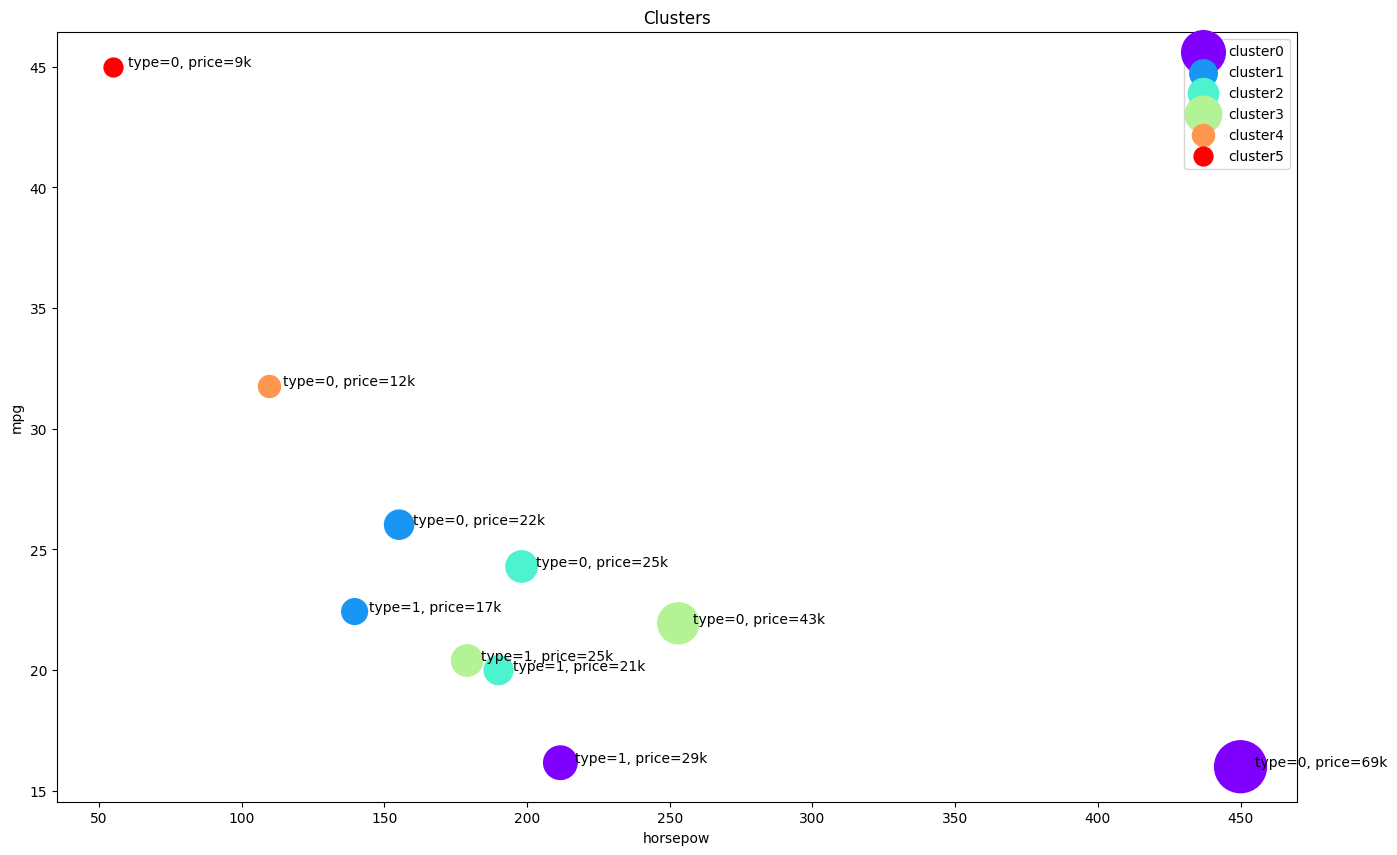

In [ ]:
plt.figure(figsize=(16,10))
for color, label in zip(colors, cluster_labels):
    subset = agg_cars.loc[(label,),]
    for i in subset.index:
        plt.text(subset.loc[i][0]+5, subset.loc[i][2], 'type='+str(int(i)) + ', price='+str(int(subset.loc[i][3]))+'k')
    plt.scatter(subset.horsepow, subset.mpg, s=subset.price*20, color=color, label='cluster'+str(label))
plt.legend()
plt.title('Clusters')
plt.xlabel('horsepow')
plt.ylabel('mpg')
